In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import timeit
import warnings
import math
import copy
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from numba import njit, prange
from tqdm import tqdm

In [ ]:
class WindowsInhibitor:
    '''Prevent OS sleep/hibernate in windows; code from:
    https://github.com/h3llrais3r/Deluge-PreventSuspendPlus/blob/master/preventsuspendplus/core.py
    API documentation:
    https://msdn.microsoft.com/en-us/library/windows/desktop/aa373208(v=vs.85).aspx'''
    ES_CONTINUOUS = 0x80000000
    ES_SYSTEM_REQUIRED = 0x00000001

    def __init__(self):
        pass

    def inhibit(self):
        import ctypes
        print("Preventing Windows from going to sleep")
        ctypes.windll.kernel32.SetThreadExecutionState(
            WindowsInhibitor.ES_CONTINUOUS | \
            WindowsInhibitor.ES_SYSTEM_REQUIRED)

    def uninhibit(self):
        import ctypes
        print("Allowing Windows to go to sleep")
        ctypes.windll.kernel32.SetThreadExecutionState(
            WindowsInhibitor.ES_CONTINUOUS)

In [ ]:
import os

osSleep = None
# in Windows, prevent the OS from sleeping while we run
if os.name == 'nt':
    osSleep = WindowsInhibitor()
    osSleep.inhibit()

# do slow stuff

# if osSleep:
#     osSleep.uninhibit()

In [2]:
K = 99 # strike price
S0 = 100 # current price of the stock
N = 50 # time steps
sigma = 0.2 # volatility
r = .06 # risk free rate 
T = 1 # year

# Binomial Tree: Option Evaluation

In [6]:
# European Option pricing using Binomial Tree
def binom(K, S0, N, sigma, r, T, optiontype='call'):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d) / (u - d)
    
    option_tree = {}
    option_tree[N] = []
    for j in range(N, -1, -1):
        price = S0*(u**j)*(d**(N-j))
        if optiontype == 'call':
            option_tree[N].append( max(price-K, 0) )
        elif optiontype == 'put':
            option_tree[N].append( max(K-price, 0) )
    
    for i in range(N-1, -1, -1):
        option_tree[i] = []
        for j in range(i+1):
            opt_price = np.exp(-r*dt)*(p*option_tree[i+1][j] + (1-p)*option_tree[i+1][j+1])
            option_tree[i].append( max(opt_price, 0) )
    
    return option_tree[0][0]


def blackschol(St, K, sigma, r, T, t, optiontype='call'):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    d1 = (1 / sigma * np.sqrt(T-t))*( np.log(St/K) + (r + (sigma**2/2))*(T-t))
    d2 = (1 / sigma * np.sqrt(T-t))*( np.log(St/K) + (r - (sigma**2/2))*(T-t))
    
    if optiontype == 'call':
        value = norm.cdf(d1)* St - norm.cdf(d2)* K * np.exp(-r *(T-t))
    elif optiontype == 'put':
        value = norm.cdf(-1*d2) * K * np.exp(-r *(T-t))  - norm.cdf(-1*d1)* St 
    
    return value

option_price = binom(K, S0, N, sigma, r, T, 'put')
print('European Call option price:', "{:.3f}".format(option_price))

European Call option price: 4.781


In [20]:
blackschol(S0, K, 0.01, r, T, 0)

6.765311175159539

In [ ]:
sigma_range = np.arange(0.1, 10.1, 0.1)
bino_price = []
bs_price = []
for s in sigma_range:
    bino_price.append( binom(K, S0, N, s, r, T) )
    bs_price.append( blackschol(S0, K, s, r, T, 0) )
    
#fig, ax = plt.subplots(2, 1, figsize=(4, 6),dpi=200)
fig = plt.figure(figsize=(4,6), dpi = 200)
plt.suptitle("European call pricing using Binomial and Black Scholes Model")
plt.subplot(2,1,1)
plt.plot(sigma_range, bino_price, label='Binomial tree estimate', linewidth=5, alpha=0.5)
plt.plot(sigma_range, bs_price, '--', c='black', label='Black-Scholes value', linewidth=1)
plt.xlabel(r"Volatility($\sigma$)")
plt.ylabel("Option price")
plt.legend(fontsize=9)

plt.subplot(2,1,2)
plt.plot(sigma_range, [abs(bino_price[i]-bs_price[i]) for i in range(len(bino_price))], c='red', 
         label=r"Residuals(|$f_{bino}-f_{BS}$|)")
plt.xlabel(r"Volatility($\sigma$)")
plt.ylabel('Magnitude of residuals')
plt.legend(fontsize=9)
plt.tight_layout()

fig.savefig('eucall_volatility.png', dpi = 200)

In [ ]:
n_range = np.arange(20, 201, 1)
bino_data = []
comptimes =[]
SETUP_CODE = '''from __main__ import binom'''

for n in n_range:
    bino_data.append( binom(K, S0, n, sigma, r, T) )
    TEST_CODE = '''binom(K=99, S0=100,N={},sigma=0.2, r=0.06, T=1)'''.format(n)
    comptimes.append(np.mean(np.divide(timeit.repeat(setup=SETUP_CODE,stmt=TEST_CODE,repeat=7,number = 3),3))) 
    
bs = blackschol(S0, K, sigma, r, T, 0)

fig = plt.figure(figsize=(4,7), dpi = 200)
plt.subplot(3,1,1)
plt.plot(n_range, bino_data, label='Binomial tree evaluation',linewidth=0.8)
plt.plot(n_range, [bs for x in range(len(bino_data))], c='black', label='Black-Scholes', linewidth=1)
plt.xlabel('Step sizes')
plt.ylabel('Option price')
plt.legend()

plt.subplot(3,1,2)
plt.plot(n_range, [abs(bs-bino_data[i]) for i in range(len(n_range))], linewidth=1, c='red', label='residual')
plt.xlabel('Step sizes')
plt.legend()

plt.subplot(3,1,3)
plt.plot(n_range, comptimes, label="Time Complexity of Binomial Tree")
plt.xlabel('Step sizes')
plt.ylabel('Time (in sec)')
plt.legend()

plt.tight_layout()
fig.savefig('eucall_convergence.png', dpi = 200)

### Hedge Parameter

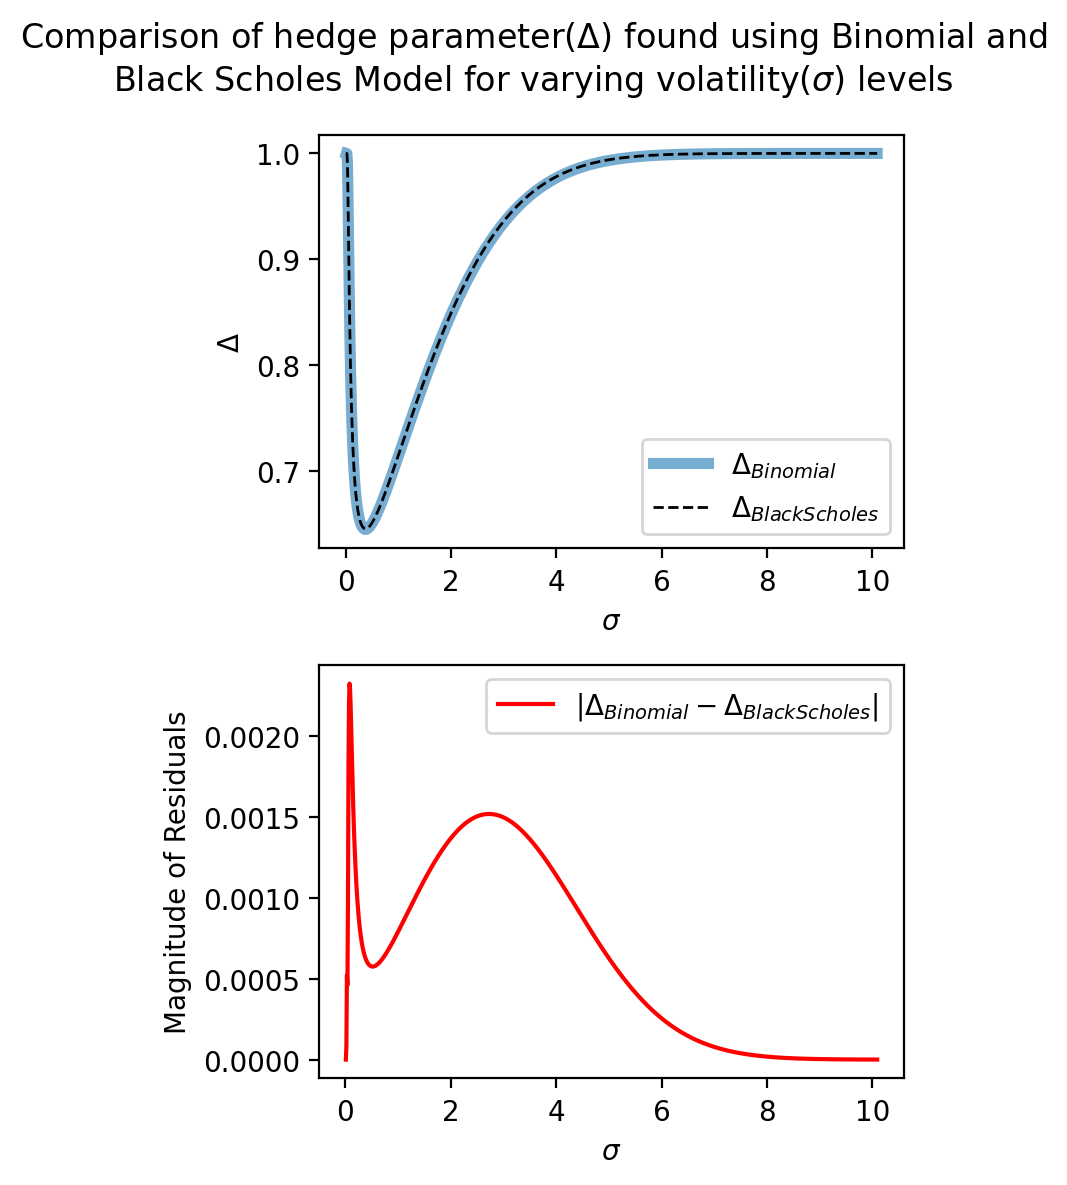

In [8]:
def hedge_analytical(St, K, sigma, r, T, t):
    d1 = (1 / sigma * np.sqrt(T-t))*( np.log(St/K) + (r + (sigma**2/2))*(T-t))
    return norm.cdf(d1)

def hedge_binom(K, S0, N, sigma, r, T):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d) / (u - d)
    
    option_tree = {}
    option_tree[N] = []
    for j in range(N, -1, -1):
        price = S0*(u**j)*(d**(N-j))
        option_tree[N].append( max(price-K, 0) )
    
    for i in range(N-1, -1, -1):
        option_tree[i] = []
        for j in range(i+1):
            opt_price = np.exp(-r*dt)*(p*option_tree[i+1][j] + (1-p)*option_tree[i+1][j+1])
            option_tree[i].append( max(opt_price, 0) )
    
    return (option_tree[1][0] - option_tree[1][1]) / (S0*(u-d))

warnings.filterwarnings("ignore", category=RuntimeWarning) 
s_range = np.arange(0, 10.1, 0.01)
analytical = []
binom = []
for s in s_range:
    analytical.append( hedge_analytical(S0, K, s, r, T, 0) )
    binom.append( hedge_binom(K, S0, N, s, r, T) ) 

fig = plt.figure(figsize=(4,6), dpi = 200)
#fig, ax = plt.subplots(2, 1, figsize=(5, 8),dpi=200)
    
plt.subplot(2,1,1)
plt.suptitle(r"Comparison of hedge parameter($\Delta$) found using Binomial and"+"\n"+ 
             r"Black Scholes Model for varying volatility($\sigma$) levels")
plt.plot(s_range, binom, label=r"$\Delta_{Binomial}$",linewidth=4,alpha=0.6)
plt.plot(s_range, analytical, '--', label=r"$\Delta_{Black Scholes}$", color='k', linewidth=1)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$\Delta$")

plt.legend()

plt.subplot(2,1,2)
plt.plot(s_range, [abs(binom[i] - analytical[i]) for i in range(len(analytical))], color='r',
         label=r"$|\Delta_{Binomial}-\Delta_{Black Scholes}|$")
plt.xlabel(r"$\sigma$")
plt.ylabel("Magnitude of Residuals")
plt.legend()
plt.tight_layout()
fig.savefig('eucall_hedge.png', dpi = 200)

### American Option

American call:  11.546
American put:  5.348


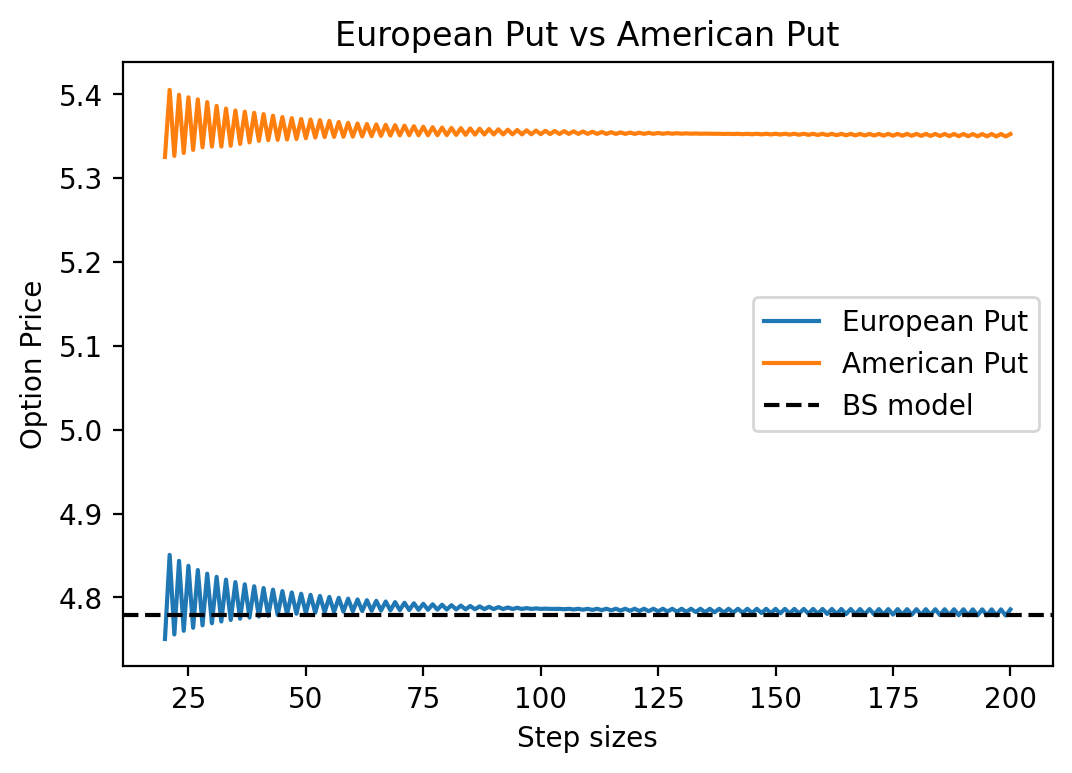

In [6]:
def american_option(K, S0, N, sigma, r, T, optiontype='call'):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d) / (u - d)
    
    tree = np.zeros((N+1, N+1))
    for i in np.arange(N+1): # iterate over rows
        for j in np.arange(i+1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            tree[i,j] = S0 * d**(i-j) * u**j
    
    stockprice = copy.deepcopy(tree)
    columns = tree.shape[1]
    rows = tree.shape[0] 
    
    if optiontype == 'call': #American Call option
        for c in np.arange(columns):
            S = tree[rows-1, c] 
            tree[rows-1, c] = max(0,S-K)

        for i in np.arange(rows-1)[::-1]:
            for j in np.arange(i+1):
                down = tree[i+1,j]
                up = tree[i+1,j+1]
                eu_value = np.exp(-r*dt) * (p*up + (1-p)*down)
                tree[i,j] = max(eu_value,stockprice[i,j]-K,0)
                
    if optiontype == 'put': #American Put option
        for c in np.arange(columns):
            S = tree[rows-1, c] 
            tree[rows-1, c] = max(0,K-S)

        for i in np.arange(rows-1)[::-1]:
            for j in np.arange(i+1):
                down = tree[i+1,j]
                up = tree[i+1,j+1]
                eu_value = np.exp(-r*dt) * (p*up + (1-p)*down)
                tree[i,j] = max(eu_value,K-stockprice[i,j],0)
        
    return tree[0,0]

print("American call: ","{:.3f}".format(american_option(K,S0,N,sigma,r,T,'call')))
print("American put: ", "{:.3f}".format(american_option(K,S0,N,sigma,r,T,'put')))

N_range = np.arange(20,201,1)
optionPriceAnalytical = blackschol(S0, K, sigma,r, T, 0,'put') 

EuropeanPut = []
AmericanPut = []

for n in N_range:
    EuropeanPut.append(binom(K,S0,n,sigma,r,T,'put')) 
    AmericanPut.append(american_option(K,S0,n,sigma,r,T,'put'))

fig = plt.figure(dpi = 200)
plt.plot(N_range, EuropeanPut, label = 'European Put')
plt.plot(N_range, AmericanPut, label = 'American Put')
plt.axhline(y=optionPriceAnalytical, ls="--", color='k', label = 'BS model')
plt.ylabel('Option Price')
plt.xlabel('Step sizes')
plt.title('European Put vs American Put')
plt.legend()
plt.show()
fig.savefig('euput_amput.png', dpi = 200)

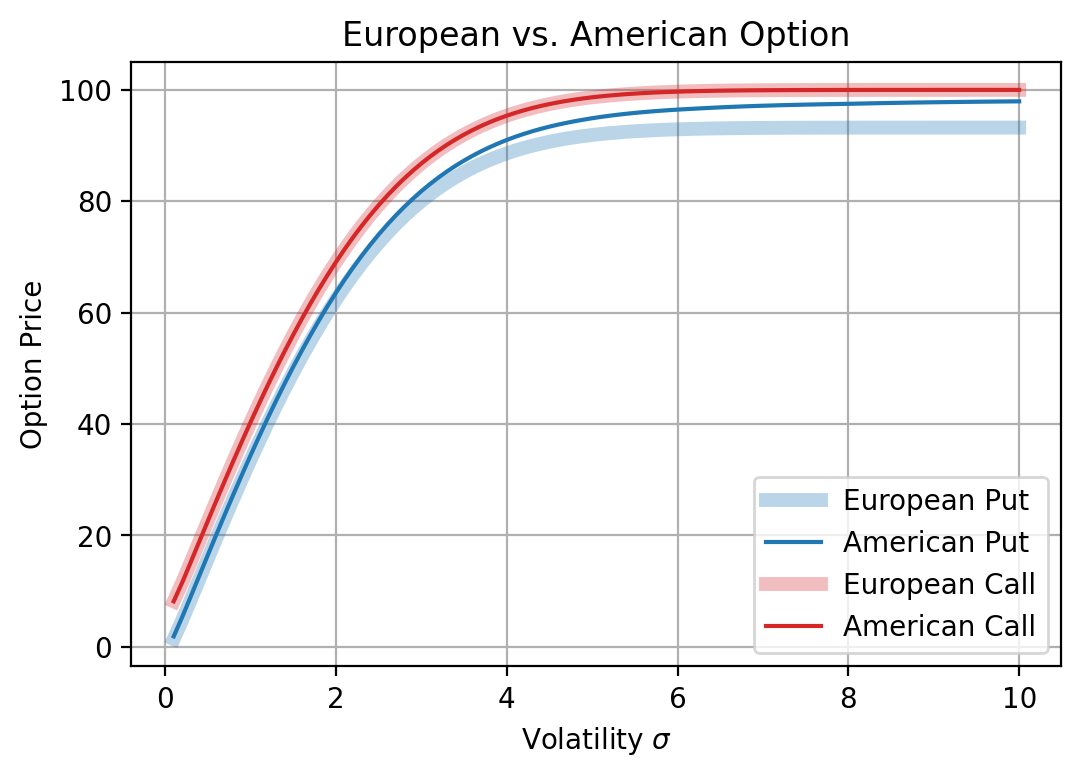

In [33]:
sigma_range = np.arange(0.1, 10.1, 0.1)
bino_price = []
bs_price = []
N = 50
#optionPriceAnalytical = blackschol(S0, K, sigma,r, T, 0,'put') 

EuropeanCall = []
AmericanCall = []
EuropeanPut = []
AmericanPut = []

for sigma in sigma_range:
    EuropeanPut.append(binom(K,S0,N,sigma,r,T,'put')) 
    AmericanPut.append(american_option(K,S0,N,sigma,r,T,'put'))
    EuropeanCall.append(binom(K,S0,N,sigma,r,T,'call'))
    AmericanCall.append(american_option(K,S0,N,sigma,r,T,'call'))
    
    
fig = plt.figure(dpi = 200)
plt.plot(sigma_range, EuropeanPut, label = 'European Put', color = 'tab:blue', lw = 5, alpha = 0.3)
plt.plot(sigma_range, AmericanPut, label = 'American Put', color = 'tab:blue')
plt.plot(sigma_range, EuropeanCall, label = 'European Call', color = 'tab:red', lw = 5, alpha = 0.3)
plt.plot(sigma_range, AmericanCall, label = 'American Call', color = 'tab:red')
#plt.axhline(y=optionPriceAnalytical, ls="--", color='k', label = 'BS model')
plt.ylabel('Option Price')
plt.xlabel('Volatility $\sigma$')
plt.title('European vs. American Option')
plt.legend()
plt.grid()
plt.show()
fig.savefig('eu_vs_am.png', dpi = 200, bbox_inches = "tight")

# Black-Scholes model: Hedging Simulations

+--------------+-------------------+
|  Asset type  | Value at time t=T |
+--------------+-------------------+
|     Cash     |       67.604      |
|     Loan     |      109.262      |
|    Delta     |       0.398       |
| Delta*Shares |       27.136      |
| Option price |       0.000       |
| Stock price  |       68.141      |
+--------------+-------------------+
Since K > S_T, the payoff is
Cash - Loan + Delta*S_T + Option short: -2.977


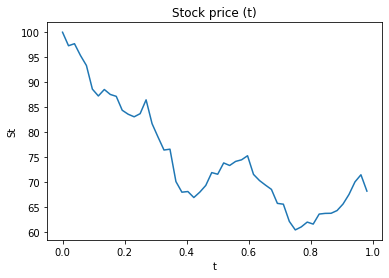

In [9]:
def hedge_sim(St, K, sigma_s, sigma_d, r, T, N):
    h_list = []
    p_list = []
    s_list = []
    dt = T/N
    t_range = np.arange(0, T, dt)
    for t in t_range:
        h_list.append( hedge_analytical(St, K, sigma_d, r, T, t) )
        bs = blackschol(St, K, sigma_d, r, T, t)
        if bs > 0:
            p_list.append(bs)
        else:
            p_list.append(0)
        s_list.append(St)
        St += r*St*dt + sigma_s*St*(np.random.normal(0, 1)*np.sqrt(dt))
        
    return h_list, p_list, t_range, s_list

## Set stock and delta volatality same for now
sigma_s = sigma_d = 0.2

N=52

h_list, p_list, t_range, s_list = hedge_sim(S0, K, sigma_s, sigma_d, r, T, N)

plt.plot(t_range, s_list)
plt.xlabel('t')
plt.ylabel('St')
plt.title('Stock price (t)')

portfolio = []
loan = {}
cash = {}
shares = 0
loan[0] = 0

for i, t in enumerate(t_range):
    delta = hedge_analytical(s_list[i], K, sigma_d, r, T, t)
    if shares < delta:
        loan[t] = (delta - shares) * s_list[i]
        cash[t] = 0
        shares = delta
    elif shares > delta:
        loan[t] = 0
        cash[t] = (shares - delta) * s_list[i]
        shares = delta

total_cash = 0
total_loan = 0
for t in cash.keys():
    total_cash += cash[t]*np.exp(r*(T-t))
    total_loan += loan[t]*np.exp(r*(T-t))

t = PrettyTable(['Asset type', 'Value at time t=T'])
t.add_row(['Cash', "{:.3f}".format(total_cash)])
t.add_row(['Loan', "{:.3f}".format(total_loan)])
t.add_row(['Delta', "{:.3f}".format(h_list[-1])])
t.add_row(["Delta*Shares","{:.3f}".format(h_list[-1]*s_list[-1]) ])
t.add_row(['Option price',"{:.3f}".format(p_list[-1])])
t.add_row(['Stock price',"{:.3f}".format(s_list[-1])])
print(t)

if s_list[-1] > K:
    print(r"Since K < S_T, the payoff is:")
    print(r"Cash - Loan + K*Delta + Option short:", "{:.3f}".format(total_cash - total_loan + K*h_list[-1]
          + p_list[np.random.randint(0, len(p_list))]))
else:
    print(r"Since K > S_T, the payoff is")
    print(r"Cash - Loan + Delta*S_T + Option short:", "{:.3f}".format(total_cash - total_loan+ h_list[-1]*s_list[-1]
          + p_list[np.random.randint(0, len(p_list))])) 

In [11]:
'''
Hedging frequencies
Daily-> N= 252 trading days in a year
Weekly-> N = 52 weeks
Quarterly-> N= 4 quarters
'''

sims = 500

hedge_freq = ["Daily","Weekly","Quarterly"]
N_vals = [252,52,4]

hedge_payoffs = {"Daily":[],"Weekly":[],"Quarterly":[]}

for k, n in enumerate(N_vals):
    
    for sim in range(sims):
        h_list, p_list, t_range, s_list = hedge_sim(S0, K, sigma_s, sigma_d, r, T, n)

        loan = {}
        cash = {}
        shares = 0
        loan[0] = 0

        for i, t in enumerate(t_range):
            delta = hedge_analytical(s_list[i], K, sigma_d, r, T, t)
            if shares < delta:
                loan[t] = (delta - shares) * s_list[i]
                cash[t] = 0
                shares = delta
            elif shares > delta:
                loan[t] = 0
                cash[t] = (shares - delta) * s_list[i]
                shares = delta

        total_cash = 0
        total_loan = 0
        for t in cash.keys():
            total_cash += cash[t]*np.exp(r*(T-t))
            total_loan += loan[t]*np.exp(r*(T-t)) 

        if s_list[-1] > K:
            cash = total_cash-total_loan+K*h_list[-1]+p_list[np.random.randint(0, len(p_list))]
            hedge_payoffs[hedge_freq[k]].append(cash)
        else:
            cash = total_cash-total_loan+h_list[-1]*s_list[-1]+p_list[np.random.randint(0, len(p_list))] 
            hedge_payoffs[hedge_freq[k]].append(cash)

In [ ]:
port_df = pd.DataFrame(data=hedge_payoffs)

fig, ax = plt.subplots(2,1,figsize=(4,5),dpi=200)
sns.set(style="darkgrid", palette="bright")
plt.suptitle("Portfolio values at T for different hedging frequency",fontsize=12)

sns.histplot(port_df,kde=True,alpha=0.5,ax=ax[0],line_kws=dict(linewidth=0.75))
ax[0].set_xlabel("Portfolio value")
sns.violinplot(data=port_df,ax=ax[1])
ax[1].set_ylabel("Portfolio value")
plt.tight_layout()

In [ ]:
'''
Simulations for same delta volatility = 0.2 and varying the stock volatility 
'''
sigma_svals = [0.05,0.1,0.2,0.3,0.4]


sigmalevels =["Stock sigma=5%","Stock sigma=10%","Stock sigma=20%", "Stock sigma=30%", "Stock sigma=40%"]
hedge_payoffs2 = {"Stock sigma=5%":[],"Stock sigma=10%":[],"Stock sigma=20%":[],"Stock sigma=30%":[],"Stock sigma=40%":[]}

for k, s in enumerate(sigma_svals):
    
    for sim in range(sims):
        h_list, p_list, t_range, s_list = hedge_sim(S0, K, s, sigma_d, r, T, n)

        loan = {}
        cash = {}
        shares = 0
        loan[0] = 0

        for i, t in enumerate(t_range):
            delta = hedge_analytical(s_list[i], K, sigma_d, r, T, t)
            if shares < delta:
                loan[t] = (delta - shares) * s_list[i]
                cash[t] = 0
                shares = delta
            elif shares > delta:
                loan[t] = 0
                cash[t] = (shares - delta) * s_list[i]
                shares = delta

        total_cash = 0
        total_loan = 0
        for t in cash.keys():
            total_cash += cash[t]*np.exp(r*(T-t))
            total_loan += loan[t]*np.exp(r*(T-t)) 

        if s_list[-1] > K:
            cash = total_cash-total_loan+K*h_list[-1]+p_list[np.random.randint(0, len(p_list))]
            hedge_payoffs2[sigmalevels[k]].append(cash)
        else:
            cash = total_cash-total_loan+h_list[-1]*s_list[-1]+p_list[np.random.randint(0, len(p_list))] 
            hedge_payoffs2[sigmalevels[k]].append(cash)

In [ ]:
port_df2 = pd.DataFrame(data=hedge_payoffs2)

fig, ax = plt.subplots(dpi=200)
sns.set(style="darkgrid", palette="bright")
plt.suptitle(r"Portfolio values at T for constant $\sigma_{\Delta}=0.2$"+"\n"+
             r"and $\sigma_{Stock}\in[0.05,0.4]$",fontsize=12)

sns.histplot(port_df2,alpha=0.5,ax=ax,line_kws=dict(linewidth=0.75))
ax.set_xlabel("Portfolio value")